In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: test_BdBKkAj.csv        
  inflating: train_aWnotuB.csv       


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import os

# Keras 및 Sklearn 모듈 임포트
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.initializers import he_normal
import keras.backend as K
from keras.callbacks import EarlyStopping

# statsmodels 임포트 (EDA용)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- 1. 데이터 로드 및 피벗 ---
# (원본 코드와 동일)
try:
    df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
    df_test = pd.read_csv('./data/test_BdBKkAj.csv', parse_dates=[0], infer_datetime_format=True)
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다. ./data/ 디렉토리에 CSV 파일이 있는지 확인하세요.")
    # 파일이 없으면 이후 실행 중지
    exit()

/tmp/ipython-input-1512674769.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
/tmp/ipython-input-1512674769.py:25: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv('./data/test_BdBKkAj.csv', parse_dates=[0], infer_datetime_format=True)


In [3]:
# Junction을 컬럼으로 피벗
train_pivoted = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
print("데이터 피벗 완료:")
print(train_pivoted.head())

데이터 피벗 완료:
Junction                1    2    3   4
DateTime                               
2015-11-01 00:00:00  15.0  6.0  9.0 NaN
2015-11-01 01:00:00  13.0  6.0  7.0 NaN
2015-11-01 02:00:00  10.0  5.0  5.0 NaN
2015-11-01 03:00:00   7.0  6.0  1.0 NaN
2015-11-01 04:00:00   9.0  7.0  2.0 NaN



EDA 1: 전체 교차로 시계열 그래프 'eda_all_junctions_timeseries.png' 저장 완료.


<Figure size 1500x700 with 0 Axes>

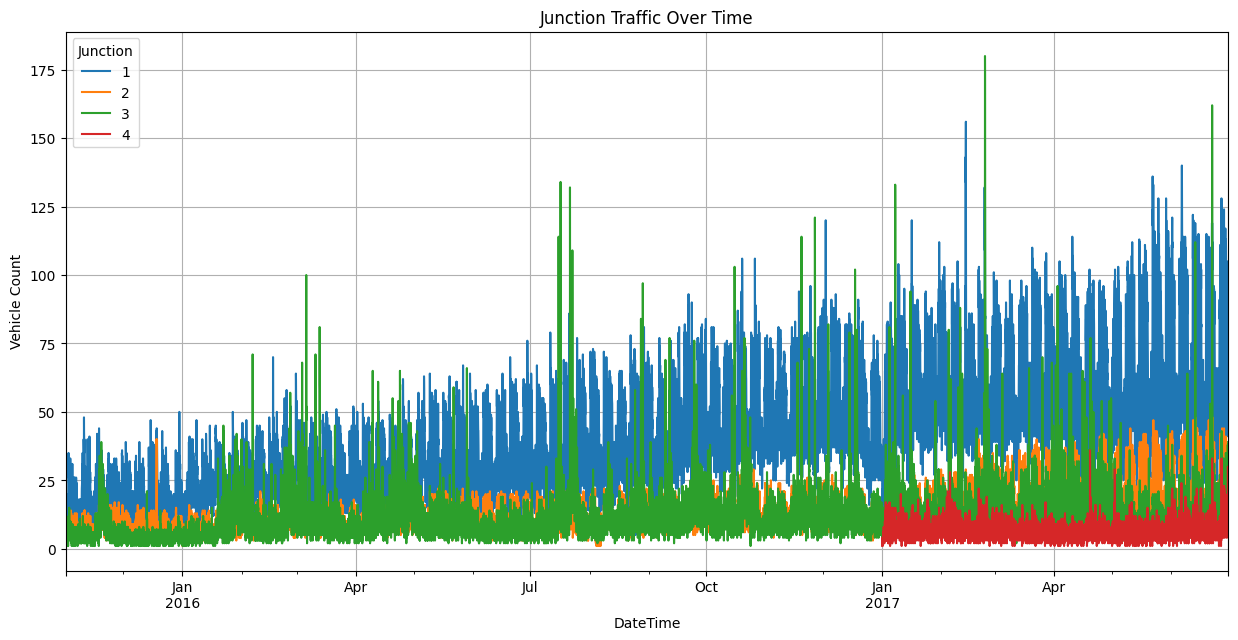

EDA 2: ACF/PACF 플롯 'eda_acf_pacf.png' 저장 완료.


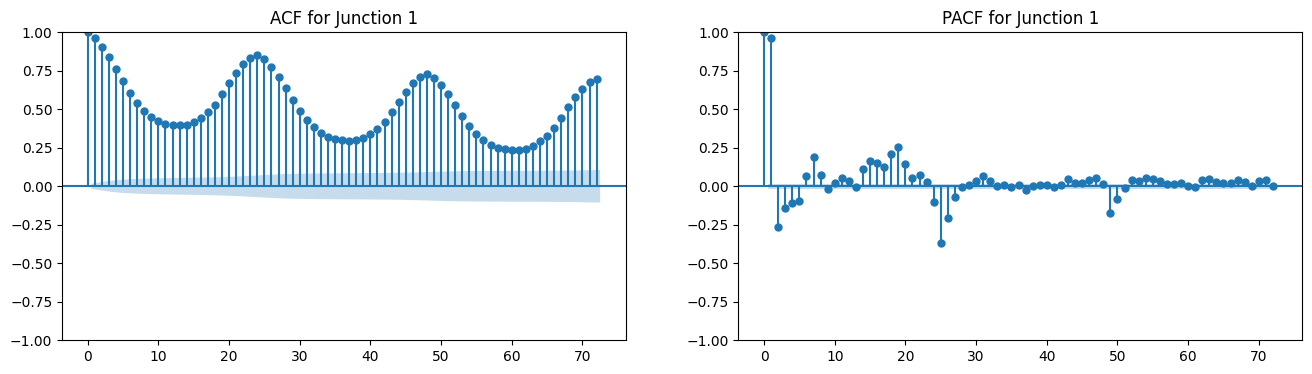

In [4]:
# --- 2. EDA (탐색적 데이터 분석) - [신규 추가] ---

# EDA 1: 전체 시계열 데이터 시각화
plt.figure(figsize=(15, 7))
train_pivoted.plot(figsize=(15, 7), subplots=False, legend=True, title='Junction Traffic Over Time')
plt.ylabel('Vehicle Count')
plt.grid(True)
plt.savefig('eda_all_junctions_timeseries.png')
print("\nEDA 1: 전체 교차로 시계열 그래프 'eda_all_junctions_timeseries.png' 저장 완료.")
plt.show()

# EDA 2: Junction 1에 대한 ACF / PACF (주기성 확인)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_pivoted[1].dropna(), lags=72, ax=axes[0], title='ACF for Junction 1') # 72시간(3일) Lags
plot_pacf(train_pivoted[1].dropna(), lags=72, ax=axes[1], title='PACF for Junction 1')
plt.savefig('eda_acf_pacf.png')
print("EDA 2: ACF/PACF 플롯 'eda_acf_pacf.png' 저장 완료.")
plt.show()

In [5]:
# --- 3. 데이터 전처리 (수정된 부분) ---

# 3-1. 결측치 처리 (수정)
# Junction 4의 대규모 결측치를 Max가 아닌 선형 보간(interpolate)으로 채우고, 시작 부분의 NaN은 0으로 채움
print("\n결측치 처리 전:\n", train_pivoted.isnull().sum())
train_filled = train_pivoted.interpolate(method='linear')
train_filled = train_filled.fillna(0)
print("\n결측치 처리 후:\n", train_filled.isnull().sum())


결측치 처리 전:
 Junction
1        0
2        0
3        0
4    10248
dtype: int64

결측치 처리 후:
 Junction
1    0
2    0
3    0
4    0
dtype: int64


In [6]:
# 3-2. 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_filled)

In [7]:
# 3-3. 시퀀스 데이터 생성 함수 (수정)
# Lookback을 24 (하루)로 설정, 4개 특징(Junctions)을 모두 사용
def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :]) # 24시간 동안의 4개 특징
        y.append(data[i + look_back, :])     # 25번째 시간의 4개 특징 (타겟)
    return np.array(X), np.array(y)

look_back = 24
X, y = create_sequences(scaled_data, look_back)

print(f"\n시퀀스 생성 완료. X shape: {X.shape}, y shape: {y.shape}")


시퀀스 생성 완료. X shape: (14568, 24, 4), y shape: (14568, 4)


In [8]:
# 3-4. 훈련/테스트 분할 (날짜 기준)
# 원본과 동일하게 2017-04-01 기준으로 분할. (시퀀스 생성으로 인해 데이터 앞부분(look_back)이 잘려나간 것을 고려해야 함)
split_index = len(train_filled[train_filled.index < '2017-04-01']) - look_back

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"훈련 데이터 (X, y): {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터 (X, y): {X_test.shape}, {y_test.shape}")

훈련 데이터 (X, y): (12384, 24, 4), (12384, 4)
테스트 데이터 (X, y): (2184, 24, 4), (2184, 4)


In [14]:
import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true), axis=-1))

# LSTM 모델 정의 (Input Shape 수정)
regressor = Sequential()
regressor.add(LSTM(
    units=50,
    activation='relu',
    kernel_initializer=he_normal(seed=0),
    input_shape=(X_train.shape[1], X_train.shape[2])  # (24, 4)
))
regressor.add(Dense(units=4)) # 4개 교차로 예측
regressor.compile(optimizer='adam', loss=root_mean_squared_error)
regressor.summary()

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n--- 모델 훈련 시작 ---")
history = regressor.fit(
    X_train, y_train,
    batch_size=120,
    epochs=100,
    validation_data=(X_test, y_test),  # 훈련 중 검증 데이터 사용
    callbacks=[early_stop],
    verbose=1
)
print("--- 모델 훈련 완료 ---\n")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,204 (43.77 KB)

 Trainable params: 11,204 (43.77 KB)

 Non-trainable params: 0 (0.00 B)


--- 모델 훈련 시작 ---
Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0749 - val_loss: 0.0738
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0365 - val_loss: 0.0564
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - val_loss: 0.0538
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0317 - val_loss: 0.0525
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0307 - val_loss: 0.0515
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0306 - val_loss: 0.0506
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0297 - val_loss: 0.0515
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0300 - val_loss: 0.0520
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293 - val_loss: 0.0499
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0291 - val_loss: 0.0489
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0289 - val_loss: 0.0495
Epoch 12/100
104/104 ━

결과 1: 훈련/검증 손실 곡선 'training_history.png' 저장 완료.


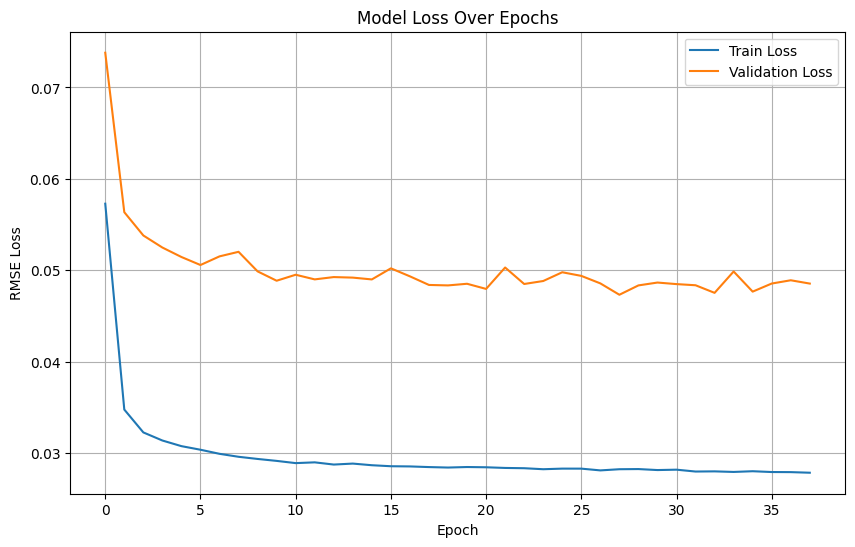

In [15]:
# --- 5. 상세 결과 분석 (추가된 부분) ---

# 결과 1: 훈련/검증 손실 곡선
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
print("결과 1: 훈련/검증 손실 곡선 'training_history.png' 저장 완료.")
plt.show()

In [16]:
# 결과 2: 테스트셋 예측 및 스케일 역변환
y_pred_scaled = regressor.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [17]:
# 결과 3: 정량적 성능 평가 (RMSE, MAE)
test_rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
test_mae = mean_absolute_error(y_test_inv, y_pred_inv)

In [18]:
print("\n--- 테스트 데이터 최종 평가 ---")
print(f"전체 교차로 평균 Test RMSE: {test_rmse:.4f}")
print(f"전체 교차로 평균 Test MAE: {test_mae:.4f}\n")


--- 테스트 데이터 최종 평가 ---
전체 교차로 평균 Test RMSE: 4.8731
전체 교차로 평균 Test MAE: 3.0538

